In [1]:
%matplotlib inline
%config InlineBackend.figure_format = True
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.utils.console import ProgressBar
import caos 

from caos import Star, Spot

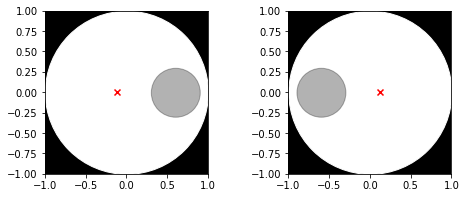

In [2]:
gj1243_t0 = Star()
gj1243_t0.spots = [Spot(x=0.6, y=0.00, r=0.30)]

gj1243_t1 = Star()
gj1243_t1.spots = [Spot(x=-0.6, y=0.00, r=0.30)]

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
gj1243_t0.plot(col=True, ax=ax[0])
gj1243_t1.plot(col=True, ax=ax[1])

In [3]:
max_photocenter_shift = 2*abs(gj1243_t0.center_of_light[0])

max_photocenter_shift

0.23750440461138841

/Users/bmmorris/git/caos/caos/catalog.py:57: RuntimeWarning: invalid value encountered in log10
  M_V = Vmag - 5*(np.log10(dist_pc) + 1)
/Users/bmmorris/git/caos/caos/catalog.py:77: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(H.T), extent=extent, cmap=plt.cm.Greys, aspect=0.2)


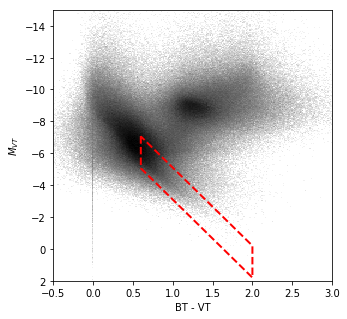

In [4]:
from caos import get_table_ms
from astropy.constants import R_sun
import astropy.units as u

fig, ax = plt.subplots(figsize=(5, 5))
table, ms = get_table_ms(ax=ax, plot=True)
fig.savefig('plots/hr.pdf', bbox_inches='tight')

In [5]:
def teff_to_radius(t_eff): 
    """Boyajian 2012"""
    X = t_eff 
    return (-8.133 + 5.09342e-3 * X - 9.86602e-7 * X**2 + 6.47963e-11 * X**3) * R_sun

gj1243_teff = 3200 # estimate for sptype = M4
R_star = teff_to_radius(gj1243_teff)

# Compute the apparent angular jitter due to sunspots at the
# distances of nearby MS stars in the TGAS sample
distances = table['distance'][ms]
jitter_rstar = max_photocenter_shift * R_star
jitter_amplitude = np.arctan((jitter_rstar/distances).decompose()).to(u.uarcsec)

# Estimate the single-measurement astrometric error for each star
# in the TGAS sample: 
astrometric_uncertainty = table['sigma_fov'][ms]/np.sqrt(table['N_fov'][ms])

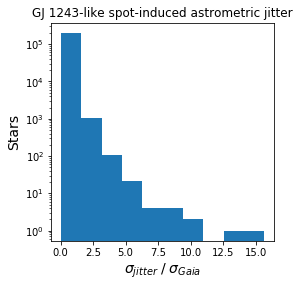

In [6]:
plt.figure(figsize=(4, 4))

plt.hist(jitter_amplitude/astrometric_uncertainty, log=True)
plt.title('GJ 1243-like spot-induced astrometric jitter')
plt.ylabel('Stars', fontsize=14)
plt.xlabel('$\sigma_{jitter} \; / \; \sigma_{Gaia}$', fontsize=14)
plt.savefig('plots/gj1243_jitter.pdf', bbox_inches='tight')

In [29]:
from astropy.table import Column

iotaHor = table['HIP'] == 12653

ms_table = table[ms]#] | iotaHor]

sigma_jitter = np.arctan((jitter_rstar/ms_table['distance']).decompose()).to(u.uarcsec)

ms_table.add_column(Column(data=sigma_jitter, name='sigma_jitter'))
#table['sigma_fov'][ms]/np.sqrt(table['N_fov'][ms])
ms_table.add_column(Column(data=ms_table['sigma_fov']/np.sqrt(ms_table['N_fov']), name='sigma_gaia'))
ms_table.add_column(Column(data=ms_table['sigma_jitter']/ms_table['sigma_gaia'], name='snr'))
#ms_table.sort('snr')

iotaHort_ms = ms_table['HIP'] == 12653

In [30]:
ms_table[np.argmax(ms_table['snr'])]

_RAJ2000,_DEJ2000,TYC,HIP,Source,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,<FG>,e_<FG>,<Gmag>,Var,BTmag,VTmag,b,sigma_fov,distance,N_fov,sigma_jitter,sigma_gaia,snr
,,,,,,,,,,,,,,,,,,,,,,,uarcsec,pc,,uarcsec,uarcsec,uarcsec
float64,float64,str12,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64
319.313623,-38.867362,7966-1201-1,105090,6583271789081861120,319.296181021,0.368,-38.8721380863,0.37,251.14,0.57,-3259.358,0.048,-1145.976,0.037,0,72008336.5146,65635.42094,5.881,NOT_AVAILABLE,8.476,6.845,44.2431493436,34.2301167882,3.98184279685,107.4,51.700454153,3.30298225288,15.6526587777


In [31]:
# plt.hist(sigma_jitter, log=True)

In [40]:
snr_gtr5 = ms_table[(ms_table['snr'] > 7) | iotaHort_ms]

In [41]:
from astroquery.simbad import Simbad

sp_types = []
main_id = []
for hip_number in snr_gtr5['HIP']:
    customSimbad = Simbad()
    customSimbad.add_votable_fields('sptype')
    query = customSimbad.query_object("HIP {0}".format(hip_number))
    sp_types.append(query['SP_TYPE'][0])
    main_id.append(query['MAIN_ID'][0])

In [42]:
sptype_colname = 'Sp Type'
mainid_colname = 'main_id'

if not sptype_colname in snr_gtr5.colnames:
    snr_gtr5.add_column(Column(data=sp_types, name=sptype_colname))

if not mainid_colname in snr_gtr5.colnames:
    snr_gtr5.add_column(Column(data=main_id, name=mainid_colname))

In [43]:
latex_table = snr_gtr5[['main_id',  'HIP', 'Sp Type', '<Gmag>', 'Plx', 'sigma_fov', 'N_fov', 'sigma_jitter', 'snr']]
latex_table.sort('snr')
latex_table = latex_table[::-1]
from astropy.io import ascii

ascii.write(latex_table, format='latex', output='data/candidates.tex')

In [46]:
snr_gtr5

_RAJ2000,_DEJ2000,TYC,HIP,Source,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,<FG>,e_<FG>,<Gmag>,Var,BTmag,VTmag,b,sigma_fov,distance,N_fov,sigma_jitter,sigma_gaia,snr,Sp Type,main_id
,,,,,,,,,,,,,,,,,,,,,,,uarcsec,pc,,uarcsec,uarcsec,uarcsec,,
float64,float64,str12,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,bytes9
4.59536,44.022958,2794-157-1,1475,385334123516493568,4.6121093103,0.288,44.024672594,0.368,280.74,0.31,2890.431,0.045,411.319,0.038,1,23518163.4717,29470.53496,7.096,NOT_AVAILABLE,10.085,8.309,18.4468682397,34.2301167882,3.5620146755,55.6,57.7940013495,4.59061620159,12.5895955601,M2V,V* GX And
103.703992,33.268178,2441-572-1,33226,939072609037892224,103.700370608,0.582,33.2665184687,0.695,180.32,0.84,-726.753,0.092,-398.289,0.058,0,5387997.89575,10644.10607,8.696,NOT_AVAILABLE,12.276,10.308,15.1319999786,34.2301167882,5.54569653949,55.6,37.1212307592,4.59061620159,8.08632852958,M3V,HD 265866
138.602828,52.686366,3806-1819-1,120005,1022456100555749632,138.592032946,0.252,52.6836126498,0.334,158.96,0.39,-1570.562,0.437,-661.004,0.336,0,26963099.7775,13028.98507,6.948,NOT_AVAILABLE,9.549,7.882,42.6663473854,34.2301167882,6.29089079014,107.4,32.7239953499,3.30298225288,9.90740877318,M0V,HD 79211
246.352597,54.304101,3878-1193-1,80459,1428427232690720000,246.355682448,0.6,54.303386196,0.539,154.08,0.6,432.131,0.063,-171.48,0.066,1,4091543.24068,8406.20587,8.995,NOT_AVAILABLE,12.34,10.372,42.7837347211,34.2301167882,6.49013499481,107.4,31.7193835148,3.30298225288,9.60325581134,M1.5V,G 202-48
293.089958,69.661177,4448-2481-1,96100,2261614294993061120,293.097120313,0.694,69.6539339679,0.976,173.6,0.91,597.482,0.031,-1738.313,0.042,0,211692225.79,1966135.61439,4.711,NOT_AVAILABLE,5.657,4.757,21.8722116967,34.2301167882,5.76036866359,58.5,35.7378308552,4.47538547321,7.98541959549,K0V,* sig Dra
344.145019,16.553432,1711-2453-1,113296,2828928003907155072,344.140521622,0.425,16.5522484176,0.316,145.98,0.51,-1034.648,0.057,-284.051,0.044,0,13838488.1938,9599.52245,7.672,NOT_AVAILABLE,10.52,8.879,38.1891190911,34.2301167882,6.85025345938,79.2,30.051892559,3.84632333845,7.81314775557,M1.5Ve,HD 216899
92.644232,-21.864645,5945-765-1,29295,2940856397828565760,92.6436196478,0.095,-21.8676236733,0.204,172.66,0.29,-136.444,0.035,-714.876,0.057,0,21479113.9394,9617.97333,7.195,NOT_AVAILABLE,10.028,8.345,18.4408537462,34.2301167882,5.7917294104,55.6,35.544319559,4.59061620159,7.74282100664,M1V,HD 42581
82.864149,-3.677228,4770-574-1,25878,3209938366665770752,82.8673288136,0.616,-3.6859464852,0.468,177.08,0.98,761.561,0.062,-2092.422,0.044,0,26035412.8151,19832.64546,6.986,NOT_AVAILABLE,9.807,8.134,19.4487710911,34.2301167882,5.64716512311,55.6,36.4542343769,4.59061620159,7.94103291935,M1.5Ve,HD 36395


In [44]:
!cat data/candidates.tex

\begin{table}
\begin{tabular}{ccccccccc}
main_id & HIP & Sp Type & <Gmag> & Plx & sigma_fov & N_fov & sigma_jitter & snr \\
 &  &  &  &  & $\mathrm{\mu arcsec}$ &  & $\mathrm{\mu arcsec}$ & $\mathrm{\mu arcsec}$ \\
V* AX Mic & 105090 & M1V & 5.881 & 251.14 & 34.2301167882 & 107.4 & 51.700454153 & 15.6526587777 \\
V* GX And & 1475 & M2V & 7.096 & 280.74 & 34.2301167882 & 55.6 & 57.7940013495 & 12.5895955601 \\
HD  79211 & 120005 & M0V & 6.948 & 158.96 & 34.2301167882 & 107.4 & 32.7239953499 & 9.90740877318 \\
G 202-48 & 80459 & M1.5V & 8.995 & 154.08 & 34.2301167882 & 107.4 & 31.7193835148 & 9.60325581134 \\
LHS  3531 & 99701 & M0V & 7.134 & 162.24 & 34.2301167882 & 69.1 & 33.3992262554 & 8.11086267873 \\
HD 265866 & 33226 & M3V & 8.696 & 180.32 & 34.2301167882 & 55.6 & 37.1212307592 & 8.08632852958 \\
* sig Dra & 96100 & K0V & 4.711 & 173.6 & 34.2301167882 & 58.5 & 35.7378308552 & 7.98541959549 \\

HD 216899 & 113296 & M1.5Ve & 7.672 & 145.98 & 34.2301167882 & 79.2 & 30.051892559 & 7.8

In [15]:
print(">3sig = {}, >5sig = {}".format(np.count_nonzero(jitter_amplitude/astrometric_uncertainty > 3), 
                                      np.count_nonzero(jitter_amplitude/astrometric_uncertainty > 5)))

>3sig = 174, >5sig = 26


### Activity cycle

(array([  1.99967000e+05,   1.36200000e+03,   1.56000000e+02,
          3.80000000e+01,   4.00000000e+00,   5.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([  0.21203897,   5.97023521,  11.72843145,  17.48662769,
         23.24482392,  29.00302016,  34.7612164 ,  40.51941264,
         46.27760887,  52.03580511,  57.79400135]),
 <a list of 10 Patch objects>)

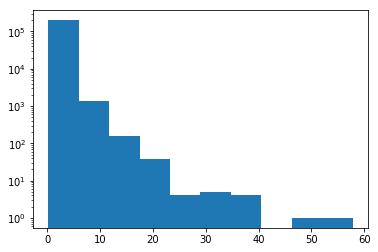

In [16]:
plt.hist(ms_table['sigma_jitter'], log=True)

In [17]:
np.argmax(ms_table['snr'])#[np.argmax(jitter_amplitude)]

191513

In [18]:
# sig = []
# ind = 15
# for i in range(100):
#     sigma_fov = ms_table['sigma_fov'][ms_snr_gtr_5][ind]
#     N_fov = ms_table['N_fov'][ms_snr_gtr_5][ind]
#     minimum = np.random.normal(loc=0, scale=sigma_fov, size=N_fov)

#     sigma_fov = ms_table['sigma_fov'][ms_snr_gtr_5][ind]
#     sigma_jitter = jitter_amplitude[ms_snr_gtr_5].value[ind]
#     N_fov = ms_table['N_fov'][ms_snr_gtr_5][ind]

#     maximum = np.random.normal(loc=0, size=N_fov,
#                                scale=np.sqrt(sigma_fov**2 + sigma_jitter**2)) 
#     sig.append(anderson_ksamp([minimum, maximum]).significance_level)

In [19]:
# plt.hist(sig)

In [20]:
# plt.hist(minimum, alpha=0.5)
# plt.hist(maximum, alpha=0.5)

In [22]:
# ms_table['snr'][high_snr], ms_table['sigma_fov'][high_snr], ms_table['sigma_jitter']

In [23]:
from scipy.stats import anderson_ksamp, ks_2samp
from astropy.utils.console import ProgressBar

n_realizations = 100

high_snr = ms_table['snr'] > 3

anderson_matrix = np.zeros((len(ms_table[high_snr]), n_realizations))
ks_matrix = np.zeros((len(ms_table[high_snr]), n_realizations))
#print(jitter_amplitude.to(u.uarcsec).value, ms_high_snr['sigma_fov'].to(u.uarcsec).value)

with ProgressBar(n_realizations, ipython_widget=True) as bar:
    for i in range(n_realizations):
        # Observe the star N_fov times at minimum
        activity_minimum = [np.random.normal(loc=0, scale=sigma_fov, size=N_fov) 
                             for sigma_fov, N_fov in 
                             zip(ms_table['sigma_fov'][high_snr].to(u.uarcsec).value, 
                                 ms_table['N_fov'][high_snr])]

        # Observe the star N_fov times at maximum
        activity_maximum = [np.random.normal(loc=0, scale=np.sqrt(sigma_fov**2 + sigma_jitter**2), size=N_fov) 
                            for sigma_fov, sigma_jitter, N_fov in 
                            zip(ms_table['sigma_fov'][high_snr].to(u.uarcsec).value, 
                                ms_table['sigma_jitter'][high_snr], 
                                ms_table['N_fov'][high_snr])]

        # Compute the significance between position distributions activity minimum and maximum
        anderson = np.array([anderson_ksamp([minimum, maximum]).significance_level 
                             for minimum, maximum in zip(activity_minimum, activity_maximum)])
        ks = np.array([ks_2samp(minimum, maximum).pvalue
                       for minimum, maximum in zip(activity_minimum, activity_maximum)])

        anderson_matrix[:, i] = anderson
        ks_matrix[:, i] = ks
        bar.update()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


In [24]:
# with ProgressBar(n_realizations, ipython_widget=True) as bar:
#     # Observe the star N_fov times at minimum
#     activity_minimum = [np.random.normal(loc=0, scale=sigma_fov, size=N_fov) 
#                          for sigma_fov, N_fov in 
#                          zip(ms_table['sigma_fov'][high_snr].to(u.uarcsec).value, 
#                              ms_table['N_fov'][high_snr])]
# #     print(table[ms][high_snr]['main_id'])
#     # Observe the star N_fov times at maximum
#     activity_maximum = [np.random.normal(loc=0, scale=np.sqrt(sigma_fov**2 + sigma_jitter**2), size=N_fov) 
#                          for sigma_fov, sigma_jitter, N_fov in 
#                          zip(ms_table['sigma_fov'][high_snr].to(u.uarcsec).value, 
#                              jitter_amplitude[high_snr].to(u.uarcsec).value, 
#                              ms_table['N_fov'][high_snr])]
#     # Compute the significance between position distributions activity minimum and maximum
#     anderson = np.array([anderson_ksamp([minimum, maximum]).significance_level 
#                          for minimum, maximum in zip(activity_minimum, activity_maximum)])
#     ks = np.array([ks_2samp(minimum, maximum).pvalue
#                    for minimum, maximum in zip(activity_minimum, activity_maximum)])

#     print(anderson, ks)

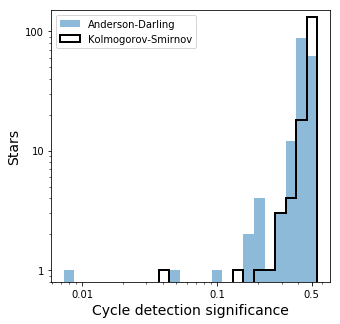

In [58]:
fig, ax = plt.subplots(figsize=(5, 5))

nbins = 25
# MIN = np.min(np.concatenate([anderson_matrix.mean(1), ks_matrix.mean(1)]))
# MAX = np.max(np.concatenate([anderson_matrix.mean(1), ks_matrix.mean(1)]))
MIN = anderson_matrix.mean(1).min()
MAX = anderson_matrix.mean(1).max()
bins = 10 ** np.linspace(np.log10(MIN), np.log10(MAX), nbins)
log = True
ax.hist(anderson_matrix.mean(1), bins=bins, log=log, label='Anderson-Darling', alpha=0.5)
ax.hist(ks_matrix.mean(1), bins=bins, histtype='step', color='k', lw=2, log=log, label='Kolmogorov-Smirnov')
ax.set_xscale("log")
ax.legend(loc='upper left')
ax.set_xlabel('Cycle detection significance', fontsize=14)
ax.set_ylabel('Stars', fontsize=14)
ax.set_yticks([1, 10, 100])
ax.set_yticklabels([1, 10, 100])
ax.set_xticks([0.01, 0.1, 0.5])
ax.set_xticklabels([0.01, 0.1, 0.5])
ax.set_ylim([0.8, 150])
fig.savefig('plots/cycle.pdf', bbox_inches='tight')

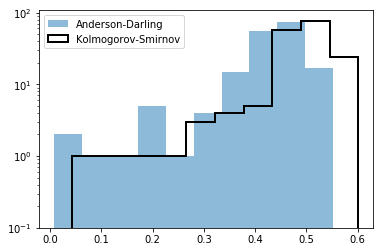

In [26]:
plt.hist(anderson_matrix.mean(1), bins=10, label='Anderson-Darling', alpha=0.5)
plt.hist(ks_matrix.mean(1), bins=10, histtype='step', color='k', lw=2, log=True, label='Kolmogorov-Smirnov')
plt.legend()

In [62]:
ms_table[high_snr]

_RAJ2000,_DEJ2000,TYC,HIP,Source,RA_ICRS,e_RA_ICRS,DE_ICRS,e_DE_ICRS,Plx,e_Plx,pmRA,e_pmRA,pmDE,e_pmDE,Dup,<FG>,e_<FG>,<Gmag>,Var,BTmag,VTmag,b,sigma_fov,distance,N_fov,sigma_jitter,sigma_gaia,snr
,,,,,,,,,,,,,,,,,,,,,,,uarcsec,pc,,uarcsec,uarcsec,uarcsec
float64,float64,str12,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64
38.972112,20.219884,1222-408-1,12097,87921519602945152,38.9732217447,0.374,20.2192993569,0.226,71.27,0.33,249.923,0.118,-140.27,0.082,0,2443053.5777,2409.92895,9.555,NOT_AVAILABLE,12.683,10.926,36.3203714865,34.2301167882,14.0311491511,79.2,14.6718617802,3.84632333845,3.81451596478
67.250516,21.9227,1277-601-1,20917,145421304810445312,67.2502149878,0.242,21.9234269246,0.129,89.04,0.26,-67.096,0.083,174.577,0.062,1,14751750.3467,16978.72329,7.603,NOT_AVAILABLE,10.112,8.509,18.0879087396,34.2301167882,11.2309074573,55.6,18.3300487289,4.59061620159,3.99293862175
75.849586,53.128469,3734-270-1,23518,266846627338158592,75.8586338986,0.282,53.1220613319,0.322,72.89,0.35,1302.877,0.116,-1537.915,0.094,0,3772451.17448,2484.22301,9.083,NOT_AVAILABLE,11.674,10.098,7.02304825233,34.2301167882,13.7193030594,52.3,15.0053599714,4.733229215,3.17021620754
89.9073,58.593012,3762-1492-1,28368,269067915704161792,89.9073727293,0.274,58.5919535624,0.284,74.19,0.33,9.084,0.097,-254.03,0.079,0,3165974.24513,3495.12838,9.274,NOT_AVAILABLE,12.193,10.43,16.5718618819,34.2301167882,13.4789055129,55.6,15.2729819766,4.59061620159,3.32700040822
69.420543,52.893615,3732-542-1,21553,272855561463141248,69.4226436986,0.732,52.8916352269,0.483,101.23,0.32,304.134,0.059,-475.143,0.041,1,11763869.7809,8948.38941,7.848,NOT_AVAILABLE,10.421,8.804,3.88623488519,34.2301167882,9.87849451744,51.9,20.8395196859,4.75143400995,4.38594319994
86.451149,62.236774,4098-1836-1,27188,283569924319916416,86.4538104567,0.097,62.2334966546,0.133,74.2,0.25,297.567,0.067,-786.542,0.072,0,7961839.80591,3777.54923,8.272,NOT_AVAILABLE,10.805,9.188,16.641093131,34.2301167882,13.4770889488,55.6,15.2750406074,4.59061620159,3.32744885146
4.276559,40.948297,2786-906-1,1368,383402900061374080,4.279687707,0.183,40.9486453026,0.146,68.09,0.25,567.223,0.065,83.523,0.052,0,8000056.14013,6012.34381,8.267,NOT_AVAILABLE,10.713,9.15,21.45924112,34.2301167882,14.6864444118,58.5,14.0172171828,4.47538547321,3.13206924111
4.59536,44.022958,2794-157-1,1475,385334123516493568,4.6121093103,0.288,44.024672594,0.368,280.74,0.31,2890.431,0.045,411.319,0.038,1,23518163.4717,29470.53496,7.096,NOT_AVAILABLE,10.085,8.309,18.4468682397,34.2301167882,3.5620146755,55.6,57.7940013495,4.59061620159,12.5895955601


In [52]:
s1 = """1.09 0.6000 1.09 0.6270 0.81 0.6650 1.07 0.5980 1.04 0.5700 1.15 0.5690 1.23 0.7620 1.21 0.5040 1.06 0.5640 1.18 0.6340 1.40 0.6000 1.35 0.5680 1.25 0.5660 1.32 0.5630 1.14 0.5500 1.20 0.5850 1.38 0.5760 1.32 0.5310 1.35 0.5360 1.28 ... 0.84 0.5840 0.93 0.4880 1.03 0.5460 0.57 0.5400 0.92 0.5300 0.53 0.5280 0.61 0.5330 0.58 0.5575 0.62 0.5230 0.54 0.5260 0.71 0.5385 0.55 0.5720 0.62 0.5480 0.80 0.5255 0.88 0.6430 0.95 0.6390 1.09 0.5990 1.02 0.6160 0.96 0.5600 0.74 0.5255 0.61 0.5175 0.89 0.5420 0.68 0.5220 0.98 0.6190 0.95 0.5370 1.05 0.5550 1.09 0.4860 1.05 0.5410 1.02 0.5290 0.96 0.4720 0.90 0.5200 0.82 0.4940 0.97 0.4860 0.99 0.5260 1.03 0.5210 1.11 0.4420 1.23 0.4850 1.02 0.5070 1.08 0.4880 1.13 0.5180 1.12 0.4840 1.15 0.5090 1.02 0.5210 0.97 0.5110 0.57 0.4863"""

s2 = """0.57 0.4990 0.58 0.5210 0.79 0.5375 0.53 0.5337 0.95 0.5420 0.55 0.5540 0.54 0.5353 0.56 0.5317 0.59 0.4737 0.64 0.4593 0.61 0.4450 0.54 0.4463 0.50 0.4370 0.60 0.4967 0.52 0.5213 0.54 0.5440 0.59 0.5480 0.55 0.5343 0.58 0.5217 0.52 0.5203 0.53 0.5370 0.55 0.5150 0.51 0.5070 0.52 0.4887 0.53 0.4933 0.58 0.4870 0.56 0.4857 0.57 0.4880 0.57 0.5193 0.56 0.4947 0.64 0.4497 0.66 0.4370 0.63 0.4497 0.57 0.4433 0.57 0.4670 0.53 0.4620 0.59 0.4940 0.62 0.4930 0.65 0.4730 0.61 0.4727 0.62 0.4707 0.58 0.4373 0.58 0.4367 0.74 0.5607 0.65 0.5207 0.61 0.5217 0.59 0.5037 0.57 0.5250 0.57 0.4713 1.48 0.4940 0.56 0.4703 0.63 0.4743"""

In [57]:

def s2f(s):
    if s == '...':
        return np.nan
    else: 
        return float(s)
    
np.nanmean(list(map(s2f, s1.split(' ')[1::2] + s2.split(' ')[1::2])))

0.52460431034482757